In [2]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    print(f'{dirname} : has {len(filenames)} images')

/kaggle/input/ : has 0 images
/kaggle/input/car-plate-detection : has 0 images
/kaggle/input/car-plate-detection/annotations : has 433 images
/kaggle/input/car-plate-detection/images : has 433 images
/kaggle/input/license-plate-characters-detection-ocr : has 1 images
/kaggle/input/license-plate-characters-detection-ocr/LP-characters : has 0 images
/kaggle/input/license-plate-characters-detection-ocr/LP-characters/annotations : has 209 images
/kaggle/input/license-plate-characters-detection-ocr/LP-characters/images : has 209 images
/kaggle/input/best-pt : has 1 images


## intuation
i will make two models  
1. car plate detector
2. charachter recognition
3. make it real-time detecor

# Car Plate Detection

### lets survey the dataset

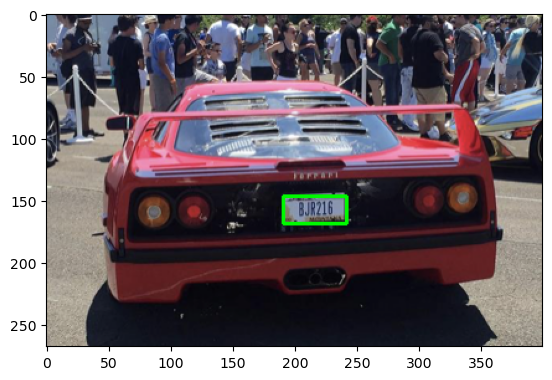

In [3]:
import glob
import cv2 as cv
from bs4 import BeautifulSoup

xml_file = '/kaggle/input/car-plate-detection/annotations/Cars13.xml'
with open(xml_file, 'r') as f:
    content = f.read()
soup = BeautifulSoup(content, 'xml')

tags = ['name', 'xmin', 'ymin', 'xmax', 'ymax', 'width', 'height']

xmin = int(soup.find('xmin').text)
xmax = int(soup.find('xmax').text)
ymin = int(soup.find('ymin').text)
ymax = int(soup.find('ymax').text)

img = cv.imread('/kaggle/input/car-plate-detection/images/Cars13.png')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
rect = cv.rectangle(img, (xmin, ymin), (xmax, ymax), (0,250,0), 2)
plt.imshow(rect)

### utility Class

In [4]:
import glob
import shutil
import re
from sklearn.model_selection import train_test_split

class PrepareData():
    def __init__(self, classes, dirs="", dir_folder="", ann_list_path=""):
        self.dirs = dirs
        self.dir_folder = dir_folder
        self.ann_list_path = ann_list_path
        self.classes = classes

    def convert_to_xywh(self, filename, width, height, xmin, ymin, xmax, ymax):

        xmin, xmax = xmin / width, xmax / width
        ymin, ymax = ymin / height, ymax/ height

        width = xmax-xmin
        height = ymax-ymin
        x_center = xmin + (width / 2)
        y_center = ymin + (height / 2)

        return x_center, y_center, width, height

    def write_label(self, file_name, objects):
        with open(file_name, 'w') as f:
            for objct in objects:
                f.write(f'{objct}\n')

    def detect_objects(self, xml_path):
        with open(xml_path, 'r') as f:
            soup = BeautifulSoup(f, 'xml')

        image_width = int(soup.find('width').text)
        image_height = int(soup.find('height').text)
        filename = soup.find('filename').text

        objects = []

        for obj in soup.find_all('object'):
            name = self.classes.index(obj.find('name').text)
            xmin = int(obj.find('xmin').text)
            ymin = int(obj.find('ymin').text)
            xmax = int(obj.find('xmax').text)
            ymax = int(obj.find('ymax').text)
            
            x_center, y_center, box_width, box_height = self.convert_to_xywh('', image_width, image_height, xmin, ymin, xmax, ymax)
            object_info = f"{name} {x_center} {y_center} {box_width} {box_height}"
            objects.append(object_info)

        return objects, filename, image_width, image_height

    def write_splits(self, ann, split, dir_folder):
        objects, filename, _, _ = self.detect_objects(ann)
        file_name = dir_folder + '/labels/' + split + '/' + filename.split('.')[0] + '.txt'
        self.write_label(file_name, objects)
        source = re.sub(r'/annotations', '/images', ann.split('.')[0] + '.' + filename.split('.')[1])
        dist   = dir_folder + '/images/' + split + '/'
        shutil.copy(source, dist)

    def build_data(self, dir_folder, ann_list):
        train, val = train_test_split(ann_list, test_size=0.1, random_state=42)
        assert len(ann_list) == (len(train) + len(val)), "Lengths do not match"
        for ann in train:
            self.write_splits(ann, 'train', dir_folder)
        for ann in val:
            self.write_splits(ann, 'val', dir_folder)

    def put_everything_together(self):
        for directory in self.dirs:
            if not os.path.exists(directory):
                os.makedirs(directory)

        ann_list = glob.glob(self.ann_list_path)
        self.build_data(self.dir_folder, ann_list)

In [5]:
dirs = ['datasets/plate/images/train', 'datasets/plate/images/val', 'datasets/plate/labels/train', 'datasets/plate/labels/val', 'datasets/plate/annotations']
dir_folder = "/kaggle/working/datasets/plate"
ann_list_path = '/kaggle/input/car-plate-detection/annotations/*'
classes = ['licence']

prepare = PrepareData(classes, dirs, dir_folder, ann_list_path)
prepare.put_everything_together()

In [6]:
import yaml

dir_folder = "/kaggle/working/datasets/plate"

data = {
    "path": dir_folder,
    "train": "images/train",
    "val": "images/val",
    "names": {0: "plate"}
    }

with open('/kaggle/working/datasets/plate/dataset.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

In [7]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.4/605.4 kB 16.6 MB/s eta 0:00:0000:01


In [7]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')
model.train(data='/kaggle/working/datasets/plate/dataset.yaml', epochs=30, imgsz=640)

100%|██████████| 6.23M/6.23M [00:00<00:00, 130MB/s]
Ultralytics YOLOv8.0.130 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/datasets/plate/dataset.yaml, epochs=30, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxe

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
train: Scanning /kaggle/working/datasets/plate/labels/train... 2561 images, 76 backgrounds, 0 corrupt: 100%|██████████| 2637/2637 [00:02<00:00, 1273.13it/s]
train: New cache created: /kaggle/working/datasets/plate/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
val: Scanning /kaggle/working/datasets/plate/labels/val... 283 images, 10 backgrounds, 0 corrupt: 100%|██████████| 293/293 [00:00<00:00, 638.49it/s]
val: New cache created: /kaggle/working/datasets/plate/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training f

In [ ]:
model.export(format='onnx')

# prediction

In [7]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n.pt')  
model = YOLO('/kaggle/input/best-pt/best.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 69.0MB/s]


In [8]:
def show_prediction(path, box):
    img = cv.imread(path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    rect = cv.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0,250,0), 2)
    plt.imshow(rect)
    
def crop_image(path, box):
    img = cv.imread(path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    dims = img[int(box[1]):int(box[3]), int(box[0]):int(box[2])]
    cropped_image = img[int(box[1]):int(box[3]), int(box[0]):int(box[2])]

    plt.imshow(cropped_image)
    
    return cropped_image

source = '/kaggle/input/car-plate-detection/images/Cars13.png'
results = model.predict(source)
boxes = results[0].boxes
box = boxes.xyxy[0].cpu().numpy()
show_prediction(source, box)

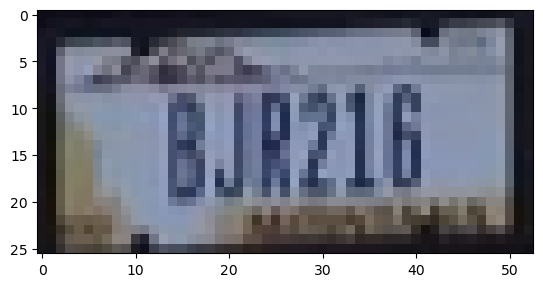

In [12]:
cropped = crop_image(source, box)

# Plate Characters detection

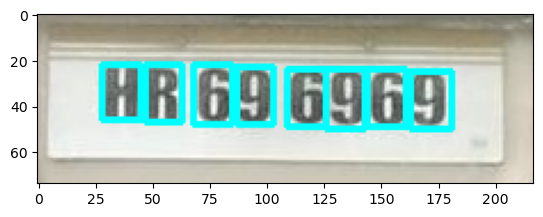

In [8]:
import glob
import math
import cv2 as cv
from bs4 import BeautifulSoup

xml_file = '/kaggle/input/license-plate-characters-detection-ocr/LP-characters/annotations/0006.xml'
classes = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z","1","2","3","4","5","6","7","8","9","0"]
objects, _ , width, height= PrepareData(classes).detect_objects(xml_file)

img = cv.imread('/kaggle/input/license-plate-characters-detection-ocr/LP-characters/images/0006.png')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

for box in objects:
    c, x, y, w, h = box.split(' ')
    w = int(float(w) * width)
    h = int(float(h) * height)
    x = int(int(float(x) * width) - (w/2))
    y = int(int(float(y) * height) - (h/2))

    rect = cv.rectangle(img, (x, y), (x+w, y+h), (0, 255, 255), 2)
    
plt.imshow(rect)

In [9]:
dirs = ['datasets/characters/images/train', 'datasets/characters/images/val', 'datasets/characters/labels/train', 'datasets/characters/labels/val', 'datasets/characters/annotations']
dir_folder = "/kaggle/working/datasets/characters"
ann_list_path = '/kaggle/input/license-plate-characters-detection-ocr/LP-characters/annotations/*'
classes = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z","1","2","3","4","5","6","7","8","9","0"]

prepare = PrepareData(classes, dirs, dir_folder, ann_list_path)
prepare.put_everything_together()

In [12]:
import yaml

dir_folder = "/kaggle/working/datasets/characters"

data = {
    "path": dir_folder,
    "train": "images/train",
    "val": "images/val",
    "names": {0:"A",1:"B",2:"C",3:"D",4:"E",5:"F",6:"G",7:"H",8:"I",9:"J",10:"K",11:"L",12:"M",13:"N",14:"O",15:"P",16:"Q",17:"R",18:"S",19:"T",20:"U",21:"V",22:"W",23:"X",24:"Y",25:"Z",26:"1",27:"2",28:"3",29:"4",30:"5",31:"6",32:"7",33:"8",34:"9",35:"0"},
    "translate": 0.2,  # image translation (+/- fraction)
    "scale": 0.2 , # image scale (+/- gain)
    "shear": 0.2,  # image shear (+/- deg) from -0.5 to 0.5
    "perspective": 0.1,  # image perspective (+/- fraction), range 0-0.001
    "flipud": 0.7,  # image flip up-down (probability)
    "fliplr": 0.5,  # image flip left-right (probability)
    "mosaic": 0.3,  # image mosaic (probability)
    "mixup": 0.1  # image mixup (probability)
    }

with open(dir_folder + '/dataset.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

In [15]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')
model.train(data='/kaggle/working/datasets/characters/dataset.yaml', epochs=60, imgsz=630)

Ultralytics YOLOv8.0.136 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/datasets/characters/dataset.yaml, epochs=60, patience=50, batch=16, imgsz=630, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=Fa

In [16]:
model.export(format='onnx')

Ultralytics YOLOv8.0.136 🚀 Python-3.10.10 torch-2.0.0 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 168 layers, 3012668 parameters, 0 gradients

PyTorch: starting from runs/detect/train4/weights/best.pt with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 40, 8400) (5.9 MB)

ONNX: starting export with onnx 1.14.0 opset 17...


[Errno 2] No such file or directory: '/opt/conda/lib/python3.10/site-packages/numpy-1.24.3.dist-info/METADATA'


ONNX: export success ✅ 0.9s, saved as runs/detect/train4/weights/best.onnx (11.7 MB)

Export complete (2.6s)
Results saved to /kaggle/working/runs/detect/train4/weights
Predict:         yolo predict task=detect model=runs/detect/train4/weights/best.onnx imgsz=640 
Validate:        yolo val task=detect model=runs/detect/train4/weights/best.onnx imgsz=640 data=/kaggle/working/datasets/characters/dataset.yaml 
Visualize:       https://netron.app


================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



'runs/detect/train4/weights/best.onnx'

In [17]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n.pt')  
model = YOLO('/kaggle/working/runs/detect/train4/weights/best.pt')

In [42]:
def show_prediction(path, boxes, clss):
    img = cv.imread(path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    classes = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z","1","2","3","4","5","6","7","8","9","0"]
    txt = []
    for box, cls in zip(boxes, clss):
        x1, y1, x2, y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
        rect = cv.rectangle(img, (x1, y1), (x2, y2), (0, 250, 0), 2)
        class_name = classes[cls]
        txt.append((x1, class_name))
        text_size, _ = cv.getTextSize(class_name, cv.FONT_HERSHEY_SIMPLEX, 0.5, 2)
        text_x = max(x1, 0)
        text_y = max(y1 - 10, 0)
        cv.rectangle(img, (text_x, text_y), (text_x + text_size[0], text_y - text_size[1]), (0, 250, 0), cv.FILLED)
        cv.putText(img, class_name, (text_x, text_y), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
    sorted_data = sorted(txt, key=lambda x: x[0])
    data = ""
    for i in sorted_data:
        print(i)
        data += i[1]
    
    plt.title(data)
    plt.imshow(rect)
    
    
def crop_image(path, box):
    img = cv.imread(path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    dims = img[int(box[1]):int(box[3]), int(box[0]):int(box[2])]
    cropped_image = img[int(box[1]):int(box[3]), int(box[0]):int(box[2])]

    plt.imshow(cropped_image)
    
    return cropped_image

source = '/kaggle/input/license-plate-characters-detection-ocr/LP-characters/images/0070.png'
results = model.predict(source)
boxes = results[0].boxes
clss =list(map(int, boxes.cls.cpu().numpy()))
boxes = boxes.xyxy.cpu().numpy()
show_prediction(source, boxes, clss)